In [1]:
# 导入依赖包
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm

#机器学习
from sklearn.base import BaseEstimator,RegressorMixin,TransformerMixin,clone
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

#忽略一些警告
import warnings
warnings.filterwarnings("ignore")


#可视化
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

1、数据总览

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#查看各列信息，主要看是否有缺失值
print("训练数据")
train.info()
#测试集数据查看
print("*"*40)
print("测试数据")
test.info()

训练数据
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 

In [5]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

2、数据分析

In [6]:
#数值型数据分析
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
# 相关性协方差表,corr()函数,返回结果接近0说明无相关性,大于0说明是正相关,小于0是负相关.
train_corr = train.drop('Id',axis=1).corr()
train_corr

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


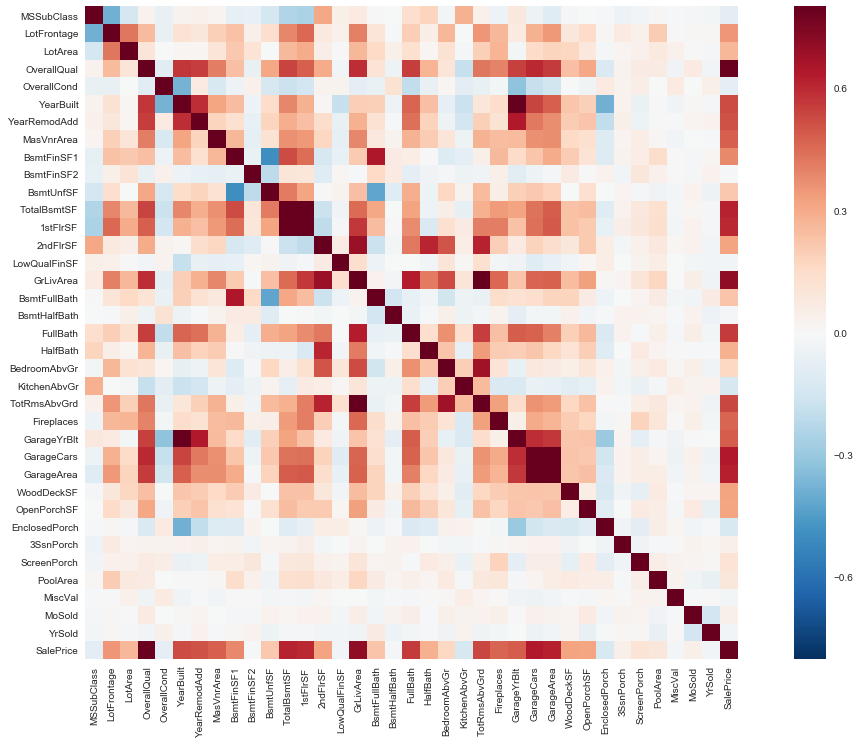

In [8]:
#画热力相关图
a = plt.subplots(figsize=(20,12)) #调整画布大小
a = sns.heatmap(train_corr,vmax=.8,square=True) #画热力图 annot=True 显示系数

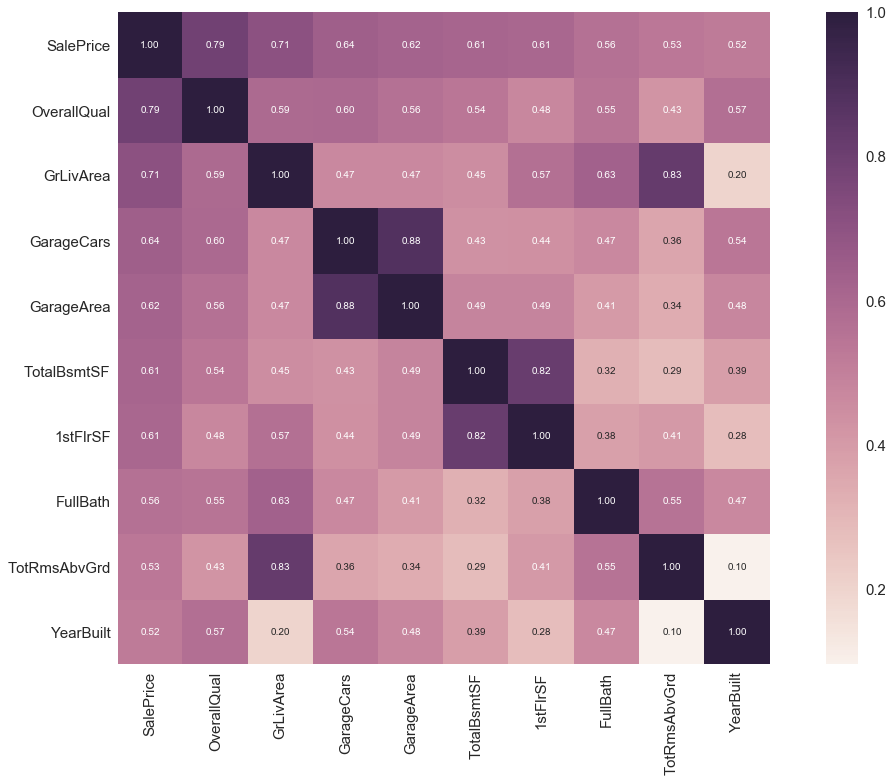

In [9]:
# 寻找K个最相关的特征信息
k = 10 # number of variables for heatmap
#print(train_corr.nlargest(k, 'SalePrice')['SalePrice'])
cols = train_corr.nlargest(k, 'SalePrice')['SalePrice'].index #nlargest查看最大的元素
#print(cols.values)
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.5)
hm = plt.subplots(figsize=(20, 12))#调整画布大小
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## 对上图进行分析
GarageCars 和 GarageAre 相关性很高、就像双胞胎一样，所以我们只需要其中的一个变量，例如：GarageCars。<br>
TotalBsmtSF  和 1stFloor 与上述情况相同，我们选择 TotalBsmtS<br>
GarageAre 和 TotRmsAbvGrd 与上述情况相同，我们选择 GarageAre

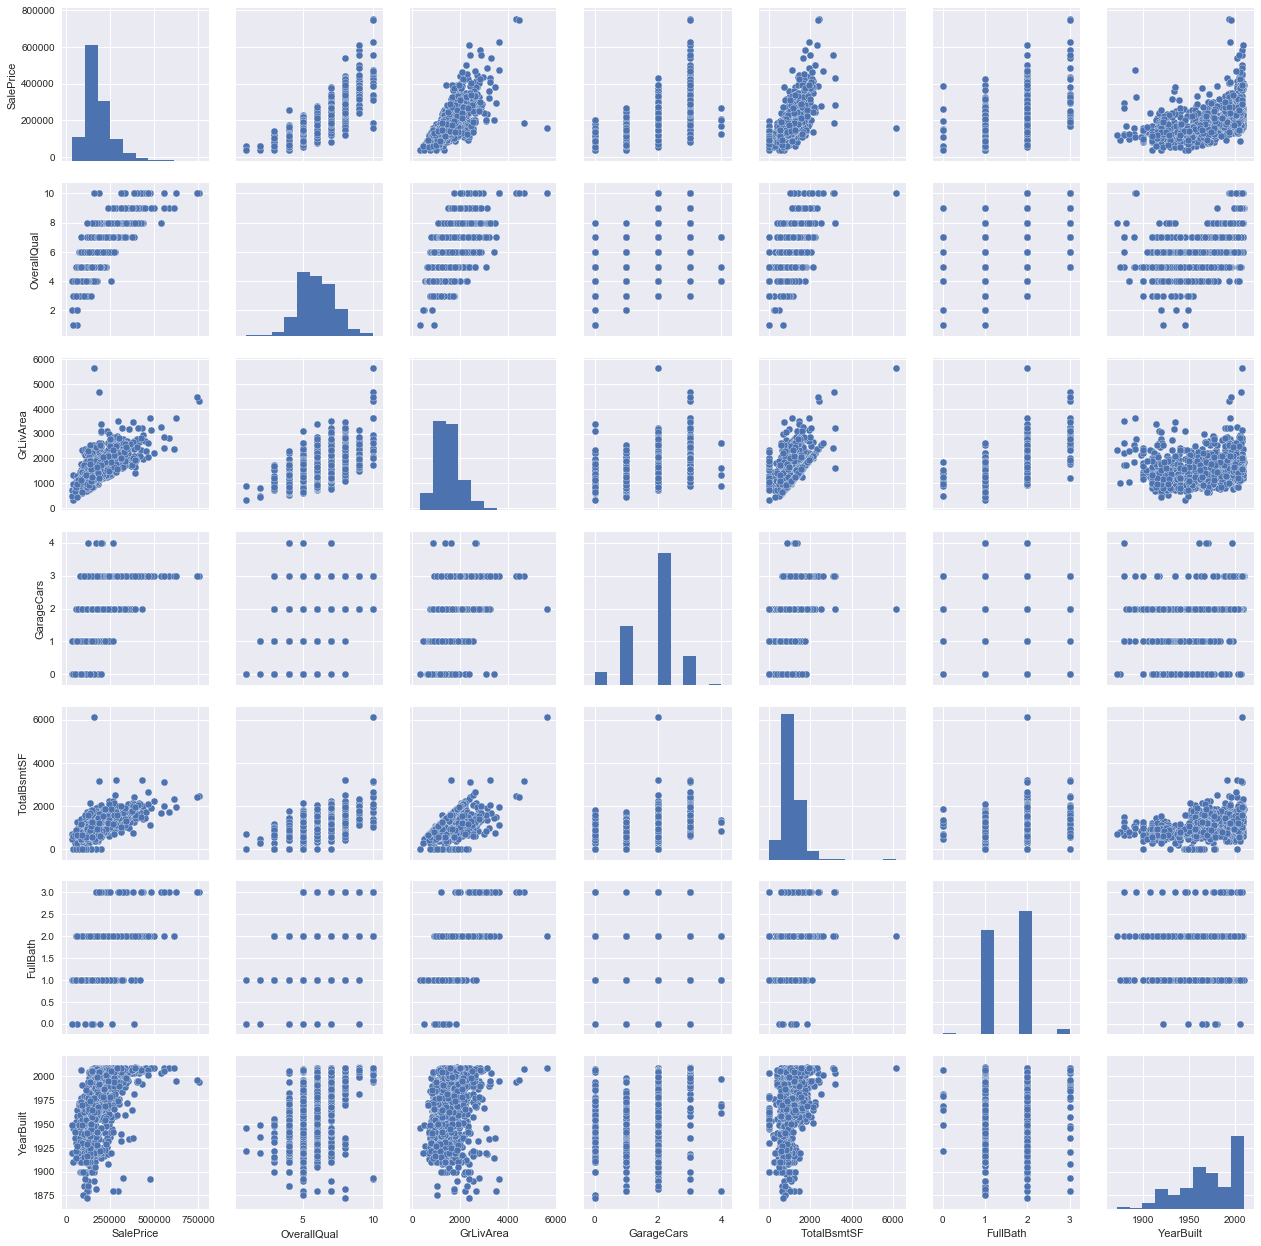

In [10]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea','GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

In [11]:
train[['SalePrice', 'OverallQual', 'GrLivArea','GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
SalePrice      1460 non-null int64
OverallQual    1460 non-null int64
GrLivArea      1460 non-null int64
GarageCars     1460 non-null int64
TotalBsmtSF    1460 non-null int64
FullBath       1460 non-null int64
YearBuilt      1460 non-null int64
dtypes: int64(7)
memory usage: 79.9 KB


3.特征工程

In [12]:
test['SalePrice'] = None
train_test = pd.concat((train, test)).reset_index(drop=True)

In [13]:
total= train_test.isnull().sum().sort_values(ascending=False)
percent = (train_test.isnull().sum()/train_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Lost Percent'])

print(missing_data[missing_data.isnull().values==False].sort_values('Total', axis=0, ascending=False).head(20))


'''
1. 对于缺失率过高的特征，例如 超过15% 我们应该删掉相关变量且假设该变量并不存在
2. GarageX 变量群的缺失数据量和概率都相同，可以选择一个就行，例如：GarageCars
3. 对于缺失数据在5%左右（缺失率低），可以直接删除/回归预测
'''

              Total  Lost Percent
PoolQC         2909      0.996574
PoolQC         2909      0.996574
MiscFeature    2814      0.964029
MiscFeature    2814      0.964029
Alley          2721      0.932169
Alley          2721      0.932169
Fence          2348      0.804385
Fence          2348      0.804385
SalePrice      1459      0.499829
SalePrice      1459      0.499829
FireplaceQu    1420      0.486468
FireplaceQu    1420      0.486468
LotFrontage     486      0.166495
LotFrontage     486      0.166495
GarageFinish    159      0.054471
GarageCond      159      0.054471
GarageCond      159      0.054471
GarageFinish    159      0.054471
GarageQual      159      0.054471
GarageYrBlt     159      0.054471


'\n1. 对于缺失率过高的特征，例如 超过15% 我们应该删掉相关变量且假设该变量并不存在\n2. GarageX 变量群的缺失数据量和概率都相同，可以选择一个就行，例如：GarageCars\n3. 对于缺失数据在5%左右（缺失率低），可以直接删除/回归预测\n'

In [14]:
train_test = train_test.drop((missing_data[missing_data['Total'] > 1]).index.drop('SalePrice') , axis=1)
# train_test = train_test.drop(train.loc[train['Electrical'].isnull()].index)

tmp = train_test[train_test['SalePrice'].isnull().values==False]
print(tmp.isnull().sum().max()) # justchecking that there's no missing data missing

1


Skewness: 1.882876
Kurtosis: 6.536282


'\n低范围的值都比较相似并且在 0 附近分布。\n高范围的值离 0 很远，并且七点几的值远在正常范围之外。\n'

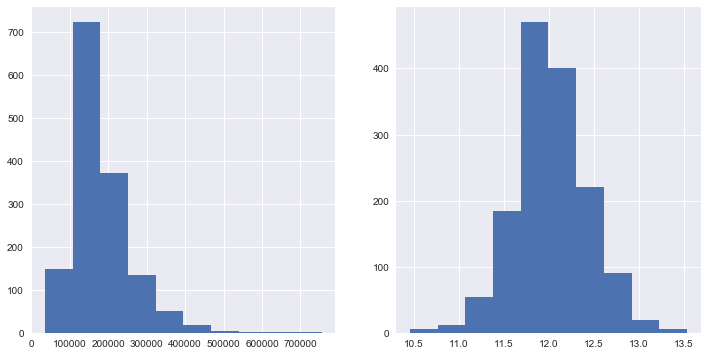

In [15]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(train.SalePrice)
ax2.hist(np.log1p(train.SalePrice))

'''
从直方图中可以看出：

* 偏离正态分布
* 数据正偏
* 有峰值
'''
# 数据偏度和峰度度量：

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

'''
低范围的值都比较相似并且在 0 附近分布。
高范围的值离 0 很远，并且七点几的值远在正常范围之外。
'''

'\n从图中可以看出：\n\n1. 有两个离群的 GrLivArea 值很高的数据，我们可以推测出现这种情况的原因。\n    或许他们代表了农业地区，也就解释了低价。 这两个点很明显不能代表典型样例，所以我们将它们定义为异常值并删除。\n2. 图中顶部的两个点是七点几的观测值，他们虽然看起来像特殊情况，但是他们依然符合整体趋势，所以我们将其保留下来。\n'

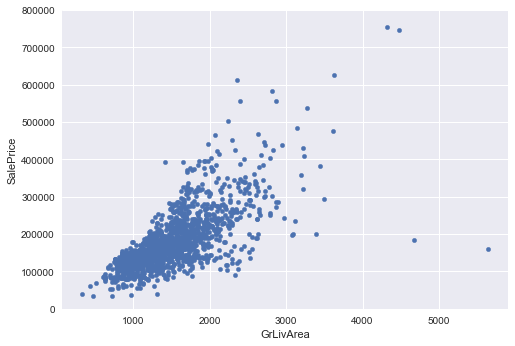

In [16]:
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

'''
从图中可以看出：

1. 有两个离群的 GrLivArea 值很高的数据，我们可以推测出现这种情况的原因。
    或许他们代表了农业地区，也就解释了低价。 这两个点很明显不能代表典型样例，所以我们将它们定义为异常值并删除。
2. 图中顶部的两个点是七点几的观测值，他们虽然看起来像特殊情况，但是他们依然符合整体趋势，所以我们将其保留下来。
'''

In [17]:
# 删除点
print(train.sort_values(by='GrLivArea', ascending = False)[:2])
tmp = train_test[train_test['SalePrice'].isnull().values==False]

train_test = train_test.drop(tmp[tmp['Id'] == 1299].index)
train_test = train_test.drop(tmp[tmp['Id'] == 524].index)

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   
523    524          60       RL        130.0    40094   Pave   NaN      IR1   

     LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature  \
1298         Bnk    AllPub    ...          480     Gd   NaN         NaN   
523          Bnk    AllPub    ...            0    NaN   NaN         NaN   

     MiscVal MoSold YrSold  SaleType  SaleCondition  SalePrice  
1298       0      1   2008       New        Partial     160000  
523        0     10   2007       New        Partial     184750  

[2 rows x 81 columns]


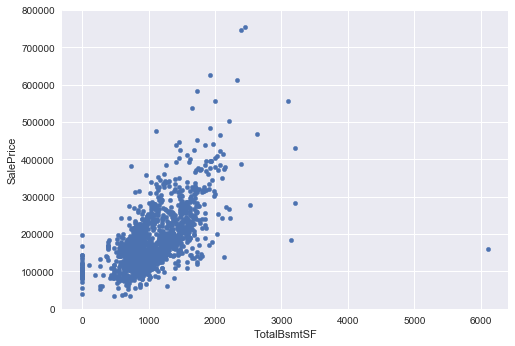

In [18]:
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'],train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice',ylim=(0,800000))

'\n可以看出，房价分布不是正态的，显示了峰值，正偏度，但是并不跟随对角线。\n可以用对数变换来解决这个问题\n'

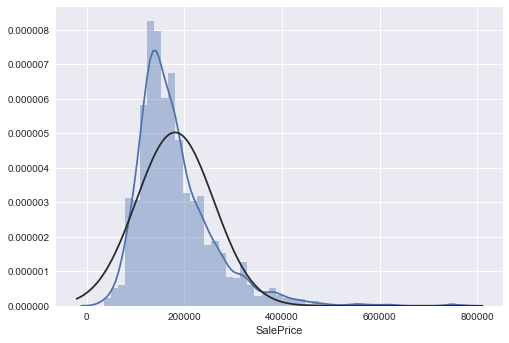

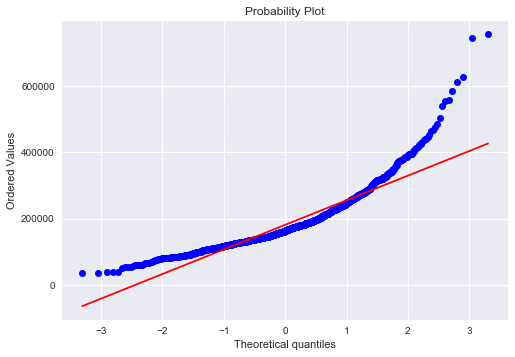

In [19]:
sns.distplot(train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

'''
可以看出，房价分布不是正态的，显示了峰值，正偏度，但是并不跟随对角线。
可以用对数变换来解决这个问题
'''

In [20]:
# 进行对数变换：
# 进行对数变换：
train_test['SalePrice'] = [i if i is None else np.log1p(i) for i in train_test['SalePrice']]

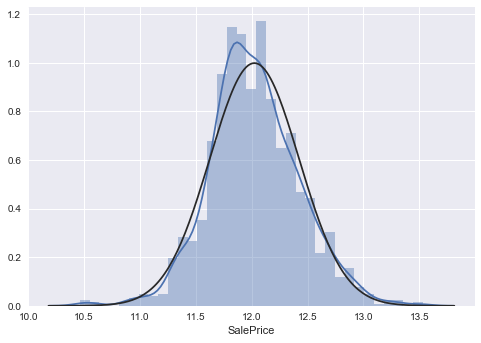

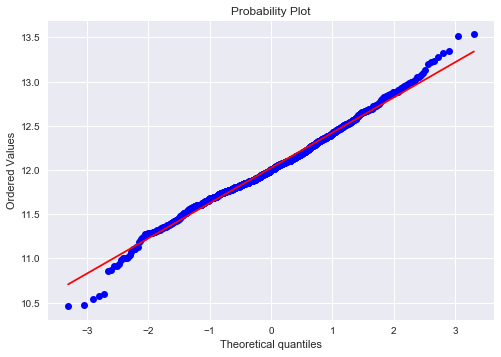

In [21]:
# 绘制变换后的直方图和正态概率图：
tmp = train_test[train_test['SalePrice'].isnull().values==False]

sns.distplot(tmp[tmp['SalePrice'] !=0]['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(tmp['SalePrice'], plot=plt)

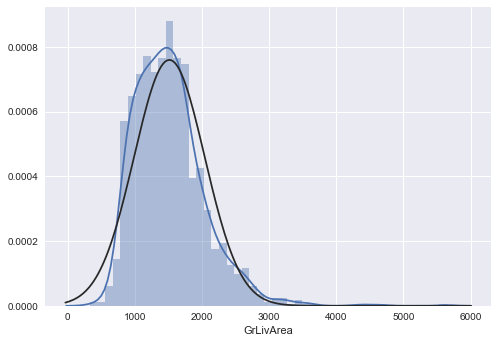

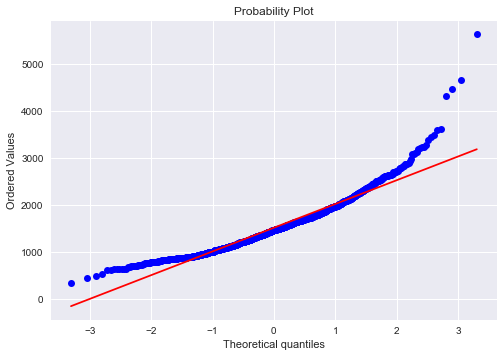

In [22]:
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

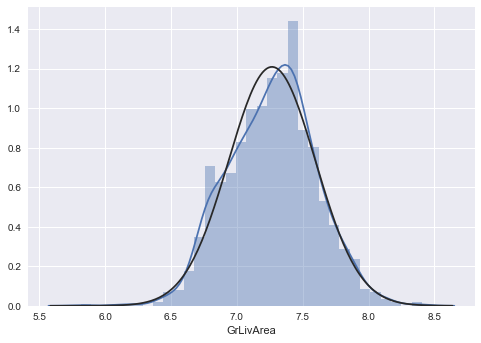

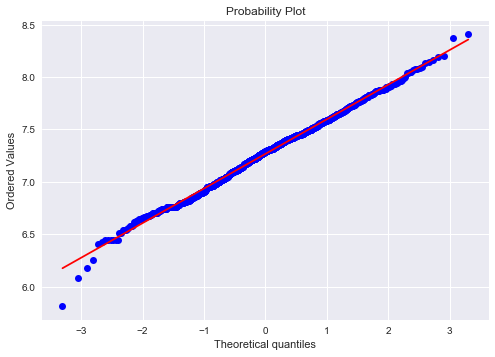

In [23]:
# 进行对数变换：
train_test['GrLivArea'] = [i if i is None else np.log1p(i) for i in train_test['GrLivArea']]

# 绘制变换后的直方图和正态概率图：
tmp = train_test[train_test['SalePrice'].isnull().values==False]
sns.distplot(tmp['GrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(tmp['GrLivArea'], plot=plt)

'\n从图中可以看出：\n* 显示出了偏度\n* 大量为 0(Y值) 的观察值（没有地下室的房屋）\n* 含 0(Y值) 的数据无法进行对数变换\n'

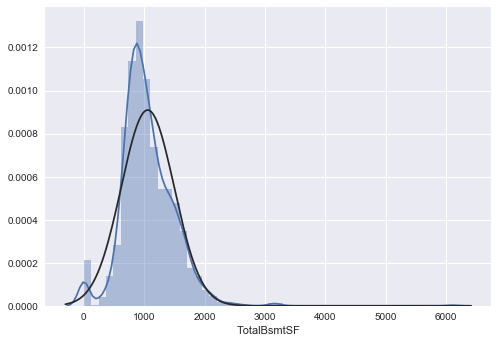

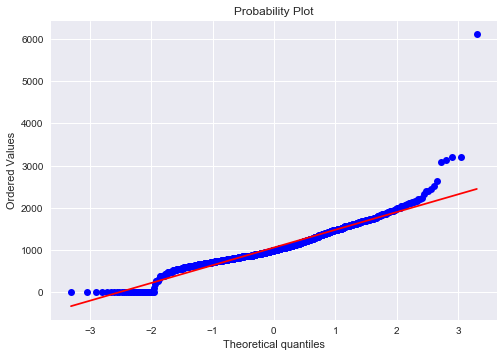

In [24]:
sns.distplot(train['TotalBsmtSF'],fit=norm);
fig = plt.figure()
res = stats.probplot(train['TotalBsmtSF'],plot=plt)

'''
从图中可以看出：
* 显示出了偏度
* 大量为 0(Y值) 的观察值（没有地下室的房屋）
* 含 0(Y值) 的数据无法进行对数变换
'''

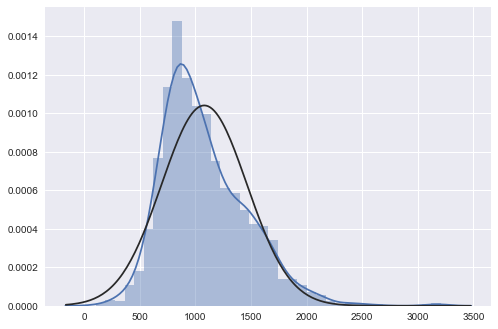

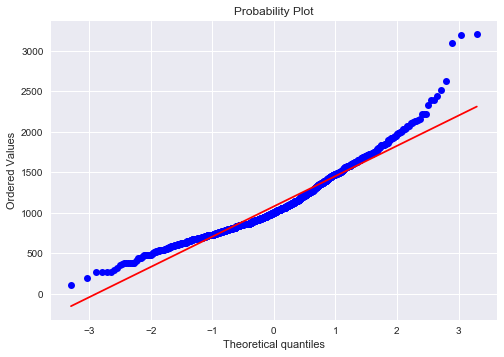

In [25]:
# 去掉为0的分布情况
tmp = train_test[train_test['SalePrice'].isnull().values==False]

tmp = np.array(tmp.loc[tmp['TotalBsmtSF']>0, ['TotalBsmtSF']])[:, 0]
sns.distplot(tmp, fit=norm)
fig = plt.figure()
res = stats.probplot(tmp, plot=plt)

In [26]:
# 我们建立了一个变量，可以得到有没有地下室的影响值（二值变量），我们选择忽略零值，只对非零值进行对数变换。
# 这样我们既可以变换数据，也不会损失有没有地下室的影响。

print(train.loc[train['TotalBsmtSF']==0, ['TotalBsmtSF']].count())
train.loc[train['TotalBsmtSF']==0,'TotalBsmtSF'] = 1
print(train.loc[train['TotalBsmtSF']==1, ['TotalBsmtSF']].count())

TotalBsmtSF    37
dtype: int64
TotalBsmtSF    37
dtype: int64


In [27]:
# 进行对数变换：
tmp = train_test[train_test['SalePrice'].isnull().values==False]

print(tmp['TotalBsmtSF'].head(10))
train_test['TotalBsmtSF']= np.log1p(train_test['TotalBsmtSF'])

tmp = train_test[train_test['SalePrice'].isnull().values==False]
print(tmp['TotalBsmtSF'].head(10))

0     856.0
1    1262.0
2     920.0
3     756.0
4    1145.0
5     796.0
6    1686.0
7    1107.0
8     952.0
9     991.0
Name: TotalBsmtSF, dtype: float64
0    6.753438
1    7.141245
2    6.825460
3    6.629363
4    7.044033
5    6.680855
6    7.430707
7    7.010312
8    6.859615
9    6.899723
Name: TotalBsmtSF, dtype: float64


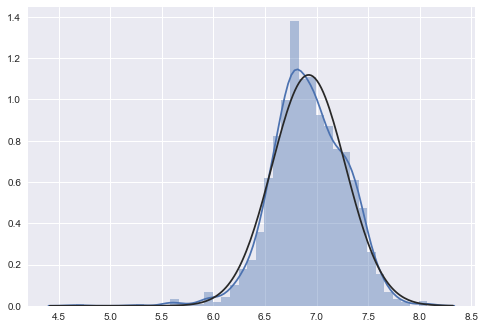

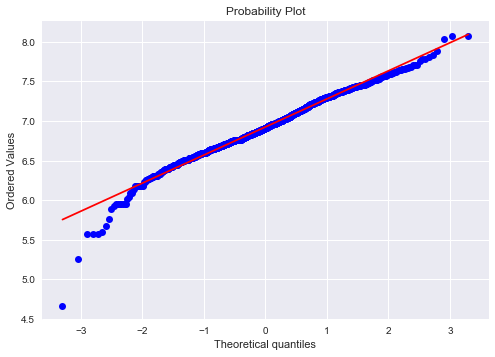

In [28]:
# 绘制变换后的直方图和正态概率图：
tmp = train_test[train_test['SalePrice'].isnull().values==False]

tmp = np.array(tmp.loc[tmp['TotalBsmtSF']>0, ['TotalBsmtSF']])[:, 0]
sns.distplot(tmp, fit=norm)
fig = plt.figure()
res = stats.probplot(tmp, plot=plt)

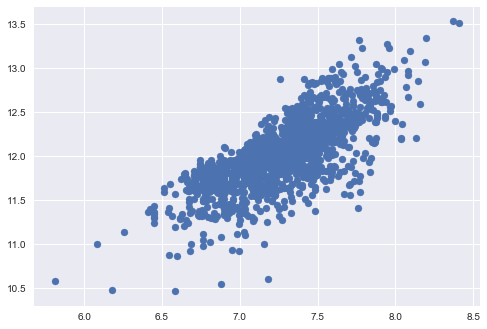

In [29]:
tmp = train_test[train_test['SalePrice'].isnull().values==False]

plt.scatter(tmp['GrLivArea'], tmp['SalePrice'])

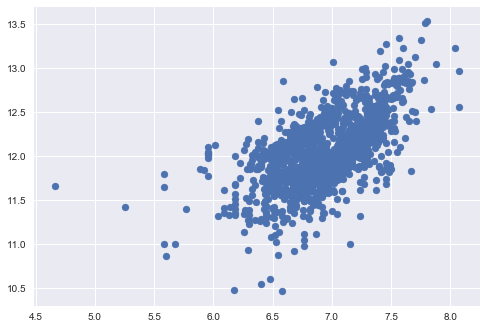

In [30]:
tmp = train_test[train_test['SalePrice'].isnull().values==False]

plt.scatter(tmp[tmp['TotalBsmtSF']>0]['TotalBsmtSF'], tmp[tmp['TotalBsmtSF']>0]['SalePrice'])

# 可以看出 SalePrice 在整个 TotalBsmtSF 变量范围内显示出了同等级别的变化。

In [31]:
tmp = train_test[train_test['SalePrice'].isnull().values==False]
tmp_1 = train_test[train_test['SalePrice'].isnull().values==True]

x_train = tmp[['OverallQual', 'GrLivArea','GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']]
y_train = tmp[["SalePrice"]].values.ravel()

x_test = tmp_1[['OverallQual', 'GrLivArea','GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']]

# 简单测试，用中位数来替代
# print(x_test.GarageCars.mean(), x_test.GarageCars.median(), x_test.TotalBsmtSF.mean(), x_test.TotalBsmtSF.median())

x_test["GarageCars"].fillna(x_test.GarageCars.median(), inplace=True)
x_test["TotalBsmtSF"].fillna(x_test.TotalBsmtSF.median(), inplace=True)

0.1664884966691243


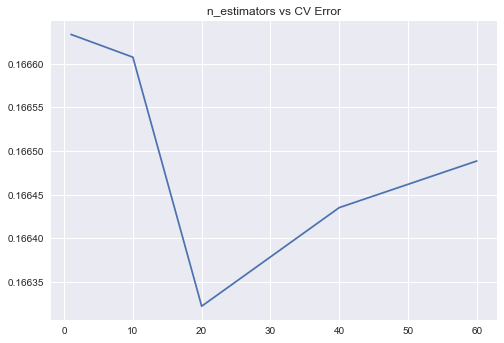

In [32]:

ridge = Ridge(alpha=0.1)

# bagging 把很多小的分类器放在一起，每个train随机的一部分数据，然后把它们的最终结果综合起来（多数投票）
# bagging 算是一种算法框架
params = [1, 10, 20, 40, 60]
test_scores = []
for param in params:
    clf = BaggingRegressor(base_estimator=ridge, n_estimators=param)
    # cv=5表示cross_val_score采用的是k-fold cross validation的方法，重复5次交叉验证
    # scoring='precision'、scoring='recall'、scoring='f1', scoring='neg_mean_squared_error' 方差值
    test_score = np.sqrt(-cross_val_score(clf, x_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

print(test_score.mean())
plt.plot(params, test_scores)
plt.title('n_estimators vs CV Error')
plt.show()

In [33]:
#Validation function
from sklearn.model_selection import KFold
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(cross_val_score(model,  x_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [34]:
# 模型选择

## LASSO Regression :
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
#Elastic Net Regression
ENet = make_pipeline(
    RobustScaler(), ElasticNet(
        alpha=0.0005, l1_ratio=.9, random_state=3))
#Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
## Gradient Boosting Regression
GBoost = GradientBoostingRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=4,
    max_features='sqrt',
    min_samples_leaf=15,
    min_samples_split=10,
    loss='huber',
    random_state=5)
## XGboost
model_xgb = xgb.XGBRegressor(
    colsample_bytree=0.4603,
    gamma=0.0468,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=1.7817,
    n_estimators=2200,
    reg_alpha=0.4640,
    reg_lambda=0.8571,
    subsample=0.5213,
    silent=1,
    random_state=7,
    nthread=-1)
## lightGBM
model_lgb = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=5,
    learning_rate=0.05,
    n_estimators=720,
    max_bin=55,
    bagging_fraction=0.8,
    bagging_freq=5,
    feature_fraction=0.2319,
    feature_fraction_seed=9,
    bagging_seed=9,
    min_data_in_leaf=6,
    min_sum_hessian_in_leaf=11)
## 对这些基本模型进行打分
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print(
    "Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(),
                                                          score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: nan (nan)

ElasticNet score: nan (nan)

Kernel Ridge score: nan (nan)

Gradient Boosting score: nan (nan)

Xgboost score: nan (nan)

LGBM score: nan (nan)



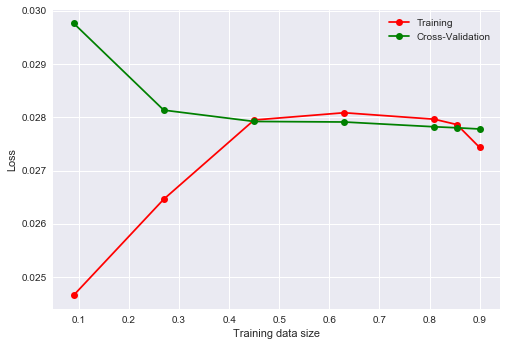

In [35]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve

ridge = Ridge(alpha=0.1)

train_sizes, train_loss, test_loss = learning_curve(ridge, x_train, y_train, cv=10, 
                                                    scoring='neg_mean_squared_error',
                                                    train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9 , 0.95, 1])

# 训练误差均值
train_loss_mean = -np.mean(train_loss, axis = 1)
# 测试误差均值
test_loss_mean = -np.mean(test_loss, axis = 1)

# 绘制误差曲线
plt.plot(train_sizes/len(x_train), train_loss_mean, 'o-', color = 'r', label = 'Training')
plt.plot(train_sizes/len(x_train), test_loss_mean, 'o-', color = 'g', label = 'Cross-Validation')

plt.xlabel('Training data size')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.show()

In [36]:
mode_br = BaggingRegressor(base_estimator=ridge, n_estimators=10)
mode_br.fit(x_train, y_train)
y_test = np.expm1(mode_br.predict(x_test))

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [41]:
# 模型融合
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack(
            [model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)


# 评价这四个模型的好坏
stacked_averaged_models = AveragingModels(models=(ENet, GBoost, KRR, lasso))
score = rmsle_cv(stacked_averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(),
                                                              score.std()))

# 最终对模型的训练和预测
# StackedRegressor
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

# XGBoost
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))
# lightGBM
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train, stacked_train_pred * 0.70 + xgb_train_pred * 0.15 +
            lgb_train_pred * 0.15))
# 模型融合的预测效果
ensemble = stacked_pred * 0.70 + xgb_pred * 0.15 + lgb_pred * 0.15
# 保存结果
result = pd.DataFrame()
result['Id'] = test_ID
result['SalePrice'] = ensemble
# index=False 是用来除去行编号
result.to_csv('../out/result.csv', index=False)

 Averaged base models score: nan (nan)



ValueError: could not convert string to float: 'Normal'